# Demonstrate building a FC network with arbitrary graph structure

> This is the foundation for building a network based on gene pathways or similar.

In [ ]:
import os

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from graphviz import Digraph
import torchviz

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Functions pulled from EnvDL.dlfn ----
def train_error_yx(dataloader, model, loss_fn, silent = False):
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)
            
            # ensure both are on cuda
            if pred.device.type == 'cpu':
                pred = pred.to('cuda')
            if y_i.device.type == 'cpu':
                y_i = y_i.to('cuda')
            
            train_loss += loss_fn(pred, y_i).item()
            
    train_loss /= num_batches
    return(train_loss)

def train_loop_yx(dataloader, model, loss_fn, optimizer, silent = False):
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    size = len(dataloader.dataset)
    for batch, (y_i, xs_i) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(xs_i)
        
        # ensure both are on cuda
        if pred.device.type == 'cpu':
            pred = pred.to('cuda')
        if y_i.device.type == 'cpu':
            y_i = y_i.to('cuda')
        
        loss = loss_fn(pred, y_i)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(y_i) 
            if not silent:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop_yx(dataloader, model, loss_fn, silent = False):
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)
            
            # ensure both are on cuda
            if pred.device.type == 'cpu':
                pred = pred.to('cuda')
            if y_i.device.type == 'cpu':
                y_i = y_i.to('cuda')
                
            test_loss += loss_fn(pred, y_i).item() 

    test_loss /= num_batches
    if not silent:
        print(f"Test Error: Avg loss: {test_loss:>8f}")
    return(test_loss)

def train_nn_yx(
    training_dataloader,
    testing_dataloader,
    model,
    batch_size = 64,
    epochs = 500,
    model_prefix = 'model',
    save_model = False,
    **kwargs # can include 'silent' for train loop or 'save_on' for saving frequency
):
    import numpy as np
    import pandas as pd
    import torch
    from torch import nn
    from tqdm import tqdm
    
    if 'optimizer' not in kwargs:
        optimizer = torch.optim.SGD(model.parameters(), lr=kwargs['learning_rate'])
    else:
        optimizer = kwargs['optimizer']
        
    if 'save_on' in kwargs:
        save_on = kwargs['save_on']
    else:
        save_on = 5       
    
    # Initialize the loss function
    loss_fn = nn.MSELoss()     

    loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
    loss_df['TrainMSE'] = np.nan
    loss_df['TestMSE']  = np.nan

    for t in tqdm(range(epochs)):        
        if 'silent' in kwargs:
            train_loop_yx(training_dataloader, model, loss_fn, optimizer, silent = kwargs['silent'])
        else:
            train_loop_yx(training_dataloader, model, loss_fn, optimizer, silent = True)

        loss_df.loc[loss_df.index == t, 'TrainMSE'
                   ] = train_error_yx(training_dataloader, model, loss_fn, silent = True)
        
        loss_df.loc[loss_df.index == t, 'TestMSE'
                   ] = test_loop_yx(testing_dataloader, model, loss_fn, silent = True)
                
    return([model, loss_df])

Using cuda device


## Example Data

In [ ]:
n_obs = 100 # 100 obs for each group
y_true = torch.from_numpy(np.concatenate([
        np.zeros((n_obs, )),
        np.ones( (n_obs, ))], 0)) + .1* torch.rand(2*n_obs,)

In [ ]:
input_tensor_dict = {
    'a1_input': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 3)),
        np.ones( (n_obs, 4, 3))], 0)),
    'a2_input': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 2)),  
        np.ones( (n_obs, 4, 2))], 0))}

x_list_temp = [input_tensor_dict[key].to(torch.float) for key in input_tensor_dict.keys()]

In [ ]:
class ListDataset(Dataset): 
    def __init__(self, 
                 y, 
                 x_list,
                 transform = None, target_transform = None,
                 **kwargs 
                ):
        self.device = device
        self.y = y 
        self.x_list = x_list
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
        x_idx =[x[idx, ] for x in self.x_list] 
        if self.target_transform:
            y_idx = self.transform(y_idx)
            x_idx = [self.transform(x) for x in x_idx]
            
        return y_idx, x_idx
    
training_dataloader = DataLoader(ListDataset(
        y = y_true[:, None].to(torch.float32),
        x_list = [e.to(torch.float32) for e in x_list_temp]
    ),
    batch_size = 20,
    shuffle = True)

## Define example graph

In [ ]:
# kegg_connections = {
#     'y_hat':['c1', 'c2'],
#     'c1':['b1'],
#     'c2':['b2'],
#     'b1':['a1_input', 'b2'],
#     'b2':['a2_input'],
#     'a1_input': [],
#     'a2_input': []
# }

kegg_connections = {
    'y_hat':['c1', 'c2', 'b2'],
    'c1':['b1'],
    'c2':['b2'],
    'b1':['a1_input', 'b2'],
    'b2':['a2_input'],
    'a1_input': [],
    'a2_input': []
}

100%|██████████| 7/7 [00:00<00:00, 73584.28it/s]


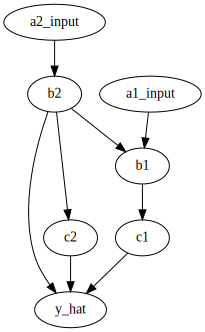

In [ ]:
dot = Digraph()
for key in tqdm(kegg_connections.keys()):
    dot.node(key)
    for value in kegg_connections[key]:
        # edge takes a head/tail whereas edges takes name pairs concatenated (A, B -> AB)in a list
        dot.edge(value, key)    

dot

Version with the node names masked for size 

In [ ]:
node_list = list(kegg_connections.keys())
for e in kegg_connections.keys():
    node_list += kegg_connections[e]
    
node_list = list(set(node_list))
node_list.sort()
node_list

['a1_input', 'a2_input', 'b1', 'b2', 'c1', 'c2', 'y_hat']

In [ ]:
default_output_size = 20
output_size_dict = dict(zip(node_list, 
                        [default_output_size for i in range(len(node_list))]))
output_size_dict['y_hat'] = 1 
output_size_dict

{'a1_input': 20,
 'a2_input': 20,
 'b1': 20,
 'b2': 20,
 'c1': 20,
 'c2': 20,
 'y_hat': 1}

In [ ]:
input_size_dict = kegg_connections.copy()

no_dependants = [e for e in kegg_connections.keys() if kegg_connections[e] == []]

# use the expected output sizes from `output_size_dict` to fill in the non-data sizes
tensor_ndim = len(input_tensor_dict[list(input_tensor_dict.keys())[0]].shape)
for e in tqdm(input_size_dict.keys()):
    # overwrite named connections with the output size of those connections
    # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict
    input_size_dict[e] = [
        (list(input_tensor_dict[ee].shape)[1]*list(input_tensor_dict[ee].shape)[2]) # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)  
        if ee in no_dependants
        else output_size_dict[ee] for ee in input_size_dict[e]]

# Now walk over entries and overwrite with the sum of the inputs
for e in tqdm(input_size_dict.keys()):
    input_size_dict[e] = np.sum(input_size_dict[e])

100%|██████████| 7/7 [00:00<00:00, 70239.54it/s]


In [ ]:
input_size_dict

{'y_hat': 60,
 'c1': 20,
 'c2': 20,
 'b1': 32,
 'b2': 8,
 'a1_input': 0.0,
 'a2_input': 0.0}

100%|██████████| 7/7 [00:00<00:00, 46976.20it/s]


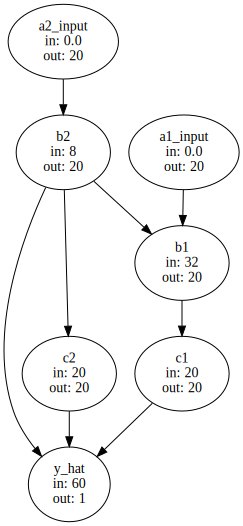

In [ ]:
dot = Digraph()
for key in tqdm(kegg_connections.keys()):
    key_label = str(key)+'\nin: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
    dot.node(key, key_label)
    for value in kegg_connections[key]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    

dot

## Get order to run

In [ ]:
# start by finding the top level -- all those keys which are theselves not values
# helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
def find_uniq_keys_values(input_dict):
    all_keys = list(input_dict.keys())
    all_values = []
    for e in all_keys:
        all_values.extend(input_dict[e])
    all_values = list(set(all_values))

    return({'all_keys': all_keys,
           'all_values': all_values})

# find the dependancies for run order from many dependancies to none
# wrapper function to find the nodes that aren't any other nodes dependancies.
def find_top_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])



In [ ]:
# find the dependancies for run order from many dependancies to none
temp = kegg_connections.copy()

dependancy_order = []
# Then iterate
for ith in range(100): #TODO <- this should be set as a input parameter
    top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
    if top_nodes == []:
        break
    else:
        dependancy_order += top_nodes    
        # remove nodes from the graph that are at the 'top' level and haven't already been removed
        for key in [e for e in dependancy_order if e in temp.keys()]:
             temp.pop(key)

                
# reverse to get the order that the nodes should be called
dependancy_order.reverse()                
dependancy_order

['a2_input', 'a1_input', 'b2', 'b1', 'c2', 'c1', 'y_hat']

## Train and Examine

In [ ]:
# Working version ====
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 input_tensor_names,
                 dependancy_order
                ):
        super(NeuralNetwork, self).__init__()
        def Linear_block(in_size, out_size, drop_pr):
            block = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr))
            return(block)   
        
        # fill in the list in dependancy order. 
        layer_list = []
        for key in dependancy_order:
            if key in input_tensor_names:
                layer_list += [
                    nn.Flatten()
                ]
            elif key != 'y_hat':
                layer_list += [
                    Linear_block(in_size=example_dict_input_size[key], 
                                 out_size=example_dict_output_size[key], 
                                 drop_pr=0)
                              ]
            else:
                layer_list += [
                    nn.Linear(example_dict_input_size[key], 
                              example_dict_output_size[key])
                              ]
                
        self.nn_layer_list = nn.ModuleList(layer_list)

        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        self.result_list = []
        self.result_list_lookup = {}
            
    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):  
            return(self.result_list[self.result_list_lookup[input_node]])
        
        # trying reinstantiating to get around inplace replacement issue.
        self.result_list = []
        self.result_list_lookup = {}
        for key in self.dependancy_order:
            input_nodes = self.example_dict[key]
            nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]

            # I realllllly hope these are being copied by reference...
            # must be first before growing result_list
            self.result_list_lookup[key] = len(self.result_list_lookup)                
            if key in self.input_tensor_names: # If the input node is an input (flatten) layer
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
                    x[self.input_tensor_lookup[key]]
                ).clone()]

            else:
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)).clone()]

        return self.result_list[self.result_list_lookup['y_hat']]

In [ ]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 


model, loss_df = train_nn_yx(
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    model,
    learning_rate = 1e-3,
    batch_size = 100,
    epochs = 200
)

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')

In [ ]:
yhat = model(next(iter(training_dataloader))[1])
torchviz.make_dot(yhat.mean(), params=dict(model.named_parameters()))

# Repeat as a Learner Class

In [ ]:
# https://github.com/glassroom/torch_lsuv_init
def LSUV_(model, data, apply_only_to=['Conv', 'Linear', 'Bilinear'],
          std_tol=0.1, max_iters=10, do_ortho_init=True, logging_FN=print):
    r"""
    Applies layer sequential unit variance (LSUV), as described in
    `All you need is a good init` - Mishkin, D. et al (2015):
    https://arxiv.org/abs/1511.06422

    Args:
        model: `torch.nn.Module` object on which to apply LSUV.
        data: sample input data drawn from training dataset.
        apply_only_to: list of strings indicating target children
            modules. For example, ['Conv'] results in LSUV applied
            to children of type containing the substring 'Conv'.
        std_tol: positive number < 1.0, below which differences between
            actual and unit standard deviation are acceptable.
        max_iters: number of times to try scaling standard deviation
            of each children module's output activations.
        do_ortho_init: boolean indicating whether to apply orthogonal
            init to parameters of dim >= 2 (zero init if dim < 2).
        logging_FN: function for outputting progress information.

    Example:
        >>> model = nn.Sequential(nn.Linear(8, 2), nn.Softmax(dim=1))                                                                                                                                                                                                                                            
        >>> data = torch.randn(100, 8)
        >>> LSUV_(model, data)
    """

    matched_modules = [m for m in model.modules() if any(substr in str(type(m)) for substr in apply_only_to)]

    if do_ortho_init:
        logging_FN(f"Applying orthogonal init (zero init if dim < 2) to params in {len(matched_modules)} module(s).")
        for m in matched_modules:
            for p in m.parameters():                
                torch.nn.init.orthogonal_(p) if (p.dim() >= 2) else torch.nn.init.zeros_(p)

    logging_FN(f"Applying LSUV to {len(matched_modules)} module(s) (up to {max_iters} iters per module):")

    def _compute_and_store_LSUV_stats(m, inp, out):
        m._LSUV_stats = { 'mean': out.detach().mean(), 'std': out.detach().std() }

    was_training = model.training
    model.train()  # sets all modules to training behavior
    with torch.no_grad():
        for i, m in enumerate(matched_modules):
            with m.register_forward_hook(_compute_and_store_LSUV_stats):
                for t in range(max_iters):
                    _ = model(data)  # run data through model to get stats
                    mean, std = m._LSUV_stats['mean'], m._LSUV_stats['std']
                    if abs(std - 1.0) < std_tol:
                        break
                    m.weight.data /= (std + 1e-6)
            logging_FN(f"Module {i:2} after {(t+1):2} itr(s) | Mean:{mean:7.3f} | Std:{std:6.3f} | {type(m)}")
            delattr(m, '_LSUV_stats')

    if not was_training: model.eval()

In [ ]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 


LSUV_(model, data = next(iter(training_dataloader))[1])

model, loss_df = train_nn_yx(
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    model,
    learning_rate = 1e-3,
    batch_size = 100,
    epochs = 200
)

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')

## Can I get summary stats for the weights over training?

In [ ]:
model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 


LSUV_(model, data = next(iter(training_dataloader))[1])

training_dataloader
testing_dataloader= training_dataloader
learning_rate = 1e-3
batch_size = 100
epochs = 200
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train_nn_yx
save_on = 5       

# Initialize the loss function
loss_fn = nn.MSELoss()     

loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
loss_df['TrainMSE'] = np.nan
loss_df['TestMSE']  = np.nan


training_stat_dict = {}

for t in tqdm(range(epochs)):        

    train_loop_yx(training_dataloader, model, loss_fn, optimizer, silent = True)

    loss_df.loc[loss_df.index == t, 'TrainMSE'
               ] = train_error_yx(training_dataloader, model, loss_fn, silent = True)

    loss_df.loc[loss_df.index == t, 'TestMSE'
               ] = test_loop_yx(testing_dataloader, model, loss_fn, silent = True)
    
    weight_bias_list=[(name, param) for name, param in model.named_parameters()]; 
    for e in weight_bias_list: 
        if e[0].split('.')[-1] == 'weight':
            with torch.no_grad():
                if e[0] not in training_stat_dict.keys():
                    training_stat_dict[e[0]] = {'mean':[e[1].mean()],
                                                'std' :[e[1].std()] }
                else:
                    training_stat_dict[e[0]]['mean'].extend([e[1].mean()])
                    training_stat_dict[e[0]]['std'].extend([e[1].std()])


# training_stat_dict


# model, loss_df

In [ ]:
for key in training_stat_dict.keys():
    training_stat_dict[key]['mean'] = torch.concat([e[None, None] for e in training_stat_dict[key]['mean']])
    training_stat_dict[key]['std'] = torch.concat([e[None, None] for e in training_stat_dict[key]['std']])
    

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Layer Means", "Layer Stds"))

for key in training_stat_dict.keys():
    fig.add_trace(
        go.Scatter(
            x = [x for x in range(epochs)], 
            y = torch.Tensor.numpy(training_stat_dict[key]['mean'])[:, 0],
            mode="lines",
            # line=go.scatter.Line(color="gray"),
            name  = key.replace('nn_layer_list.', ''),
            showlegend=False),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x = [x for x in range(epochs)], 
            y = torch.Tensor.numpy(training_stat_dict[key]['std'])[:, 0],
            mode="lines",
            # line=go.scatter.Line(color="gray"),
            name  = key.replace('nn_layer_list.', ''),
            showlegend=False),
        row=1, col=2
    )
    
fig.update_layout(#height=500, width=700,
    title_text="Layerwise Weight Statistics over Training")
fig.show()

## Using slices of a tensor instead of a list of tensors

In [ ]:
# length of all the genes -> slice positions
# print([e.shape[-1] for e in x_list_temp])

slice_pos = np.cumsum([e.shape[-1] for e in x_list_temp])
# set up an array with the start/end of each gene slice in each row
slice_idx = np.zeros((slice_pos.shape[0], 2))
slice_idx[1:, 0] = slice_pos[:-1]
slice_idx[ :, 1] = slice_pos

slice_idx = slice_idx.astype(int)
print(slice_idx)

x_list_temp_cat = torch.concat(x_list_temp, axis = 2)

# here's how to slice one of these concatenated tensors to get the desired part. 
x_list_temp_cat[:, :, slice_idx[0, 0]:slice_idx[0, 1]].shape

In [ ]:
# Don't even have to subclass the dataloader, just drop the single tensor into a list.
training_dataloader = DataLoader(ListDataset(
        y = y_true[:, None].to(torch.float32),
        x_list = [e.to(torch.float32) for e in [x_list_temp_cat]]
    ),
    batch_size = 20,
    shuffle = True)

In [ ]:
# Working version ====
class NeuralNetworkV2(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 input_tensor_names,
                 input_tensor_slice_idxs,
                 dependancy_order
                ):
        super(NeuralNetworkV2, self).__init__()
        def Linear_block(in_size, out_size, drop_pr):
            block = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr))
            return(block)   
        
        # fill in the list in dependancy order. 
        layer_list = []
        for key in dependancy_order:
            if key in input_tensor_names:
                layer_list += [
                    nn.Flatten()
                ]
            elif key != 'y_hat':
                layer_list += [
                    Linear_block(in_size=example_dict_input_size[key], 
                                 out_size=example_dict_output_size[key], 
                                 drop_pr=0)
                              ]
            else:
                layer_list += [
                    nn.Linear(example_dict_input_size[key], 
                              example_dict_output_size[key])
                              ]
                
        self.nn_layer_list = nn.ModuleList(layer_list)

        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        
        # I can use the lookup in the original class to get the right slice indexes!
        self.input_tensor_slice_idxs = input_tensor_slice_idxs


        self.result_list = []
        self.result_list_lookup = {}
            
    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):  
            return(self.result_list[self.result_list_lookup[input_node]])
        
        # trying reinstantiating to get around inplace replacement issue.
        self.result_list = []
        self.result_list_lookup = {}
        for key in self.dependancy_order:
            input_nodes = self.example_dict[key]
            nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]

            # I realllllly hope these are being copied by reference...
            # must be first before growing result_list
            self.result_list_lookup[key] = len(self.result_list_lookup)                
            if key in self.input_tensor_names: # If the input node is an input (flatten) layer
                gene_idx = self.input_tensor_lookup[key]
                
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
                    # instead of looking up a list index now x is sliced
                    x[0][:, :, self.input_tensor_slice_idxs[gene_idx, 0]:self.input_tensor_slice_idxs[gene_idx, 1]]
                ).clone()] # clone could be the source of my problems too.

            else:
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)).clone()]

        return self.result_list[self.result_list_lookup['y_hat']]

In [ ]:
model = NeuralNetworkV2(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      input_tensor_slice_idxs= slice_idx,
                      dependancy_order = dependancy_order) 

In [ ]:
model, loss_df = train_nn_yx(
    training_dataloader,
    training_dataloader, # For demo, the training and testing data are the same.
    model,
    learning_rate = 1e-3,
    batch_size = 100,
    epochs = 200
)

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')
# no apparant time savings here.

# Trying with sparse maticies:

In [ ]:
# input_tensor_dict = {
#     'a1_input': torch.from_numpy(np.concatenate([
#         np.zeros((n_obs, 4, 3)),
#         np.ones( (n_obs, 4, 3))], 0)),
#     'a2_input': torch.from_numpy(np.concatenate([
#         np.zeros((n_obs, 4, 2)),  
#         np.ones( (n_obs, 4, 2))], 0))}

# x_list_temp = [input_tensor_dict[key].to(torch.float) for key in input_tensor_dict.keys()]

In [ ]:
# n_obs = 1
# snps = torch.from_numpy(
#     np.concatenate([
#         # a1_input
#         np.concatenate([
#             np.ones((n_obs, 4, 3))*1.1,
#             np.ones((n_obs, 4, 3))*2.1  
#             ], 0),
#         # a2_input
#         np.concatenate([
#             np.ones((n_obs, 4, 2))*1.2,  
#             np.ones((n_obs, 4, 2))*2.2
#             ], 0),
#         ], 2))

# snps[0]    

In [ ]:
# snp_adj_matrix = torch.tensor([
#     [1, 1, 1, 0, 0], # a1_input
#     [0, 0, 0, 0, 0],
#     [0, 0, 0, 1, 1], # a2_input
#     [0, 0, 0, 0, 0]  
#     ]).to(float)

# snp_w_matrix = torch.randn(4, 5)
# snp_b_matrix = torch.randn(4,)

# inp = snps[0] @ torch.Tensor.transpose(snp_adj_matrix*snp_w_matrix, 1, 0) + snp_b_matrix
# inp

In [ ]:
# import einops

# snps = torch.Tensor(
#     [[[0,0,0,1],
#       [0,0,0,1],
#       [1,0,0,0]]]
#     )
# # set to batch nucleotide gene then flatten.
# snps = einops.rearrange(snps, 'b g n -> b n g').flatten()

# a1_input_pos = (0,  8) 
# a2_input_pos = (8, 12) 

# snp_adj_matrix = torch.tensor([0.0]).repeat(snps.shape[0], snps.shape[0])
# snp_adj_matrix[0, 0:4*2] = 1.0
# snp_adj_matrix[4*2, 4*2:(4*2+4*1)] = 1.0
# snp_adj_matrix

# snp_w_matrix = torch.randn(snps.shape[0], snps.shape[0])
# snp_b_matrix = torch.randn(1,)

# out1 = snps @ (snp_adj_matrix*snp_w_matrix).transpose(0, 1) 

# out1 = out1[
#     [a1_input_pos[0],
#      a2_input_pos[0]]
#     ] + snp_b_matrix


# snp_adj_matrix = torch.tensor([
# #a1  a2  b1  b2  c1  c2  yhat
# [0., 0., 1., 0., 0., 0., 0.],# a1 
# [0., 0., 0., 1., 0., 0., 0.],# a2 
# [0., 0., 0., 0., 1., 0., 0.],# b1 
# [0., 0., 1., 0., 1., 0., 0.],# b2 
# [0., 0., 0., 0., 0., 0., 1.],# c1 
# [0., 0., 0., 0., 0., 0., 1.],# c2 
# [0., 0., 0., 0., 0., 0., 0.] # yhat
# ])

# out1

# # nn.ReLU()(out1)


# snp_adj_matrix


# # torch.flatten(snp_adj_matrix)



In [ ]:
temp = kegg_connections.copy()
# temp['y_hat'] = ['c1', 'c2', 'b1']

temp

{'y_hat': ['c1', 'c2', 'b2'],
 'c1': ['b1'],
 'c2': ['b2'],
 'b1': ['a1_input', 'b2'],
 'b2': ['a2_input'],
 'a1_input': [],
 'a2_input': []}

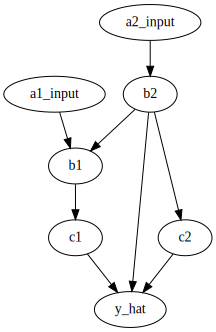

In [ ]:
dot = Digraph()
for key in temp.keys():
    for value in temp[key]: 
        dot.edge(value, key)
dot

In [ ]:
dependancy_order

['a2_input', 'a1_input', 'b2', 'b1', 'c2', 'c1', 'y_hat']

In [ ]:
# propose chunk

def get_current_window(available_nodes:list, # ordered list of nodes
                       connection_dict: dict, # dict of connections with parent->[children]
                       node_list_is_ordered:bool = True # If the node list isn't ordered then all will be searched
                       ):
    current_window = []
    for j in range(len(available_nodes)):
        prop_node = available_nodes[j]
        # does proposed node need any nodes in the current window?
        if True not in [True if e in current_window else False for e in connection_dict[prop_node]]:
            current_window += [prop_node]
        else:
            if node_list_is_ordered:
                break
            else: # If the node list isn't ordered then all will be searched
                pass
    return current_window


# get_current_window(available_nodes = dependancy_order,
#                    connection_dict = temp,
#                    node_list_is_ordered = True)


# These are the nodes that can be in each matrix without being needed for the next output. 
# This is _not_ including the nodes that need to be kept around as input for future nodes.
temp_nodes = dependancy_order.copy()
nodes_in_matrices = []

for _ in range(len(temp_nodes)):
    if temp_nodes == []:
        break
    else:
        nodes_in_matrices += [
            get_current_window(available_nodes = temp_nodes,
                        connection_dict = temp,
                        node_list_is_ordered = True)]

        temp_nodes = [e for e in temp_nodes if e not in nodes_in_matrices[-1]]
        print(nodes_in_matrices)


[['a2_input', 'a1_input']]
[['a2_input', 'a1_input'], ['b2']]
[['a2_input', 'a1_input'], ['b2'], ['b1', 'c2']]
[['a2_input', 'a1_input'], ['b2'], ['b1', 'c2'], ['c1']]
[['a2_input', 'a1_input'], ['b2'], ['b1', 'c2'], ['c1'], ['y_hat']]


In [ ]:
nodes_as_matricies = dict(zip([i for i in range(len(nodes_in_matrices))], 
                              nodes_in_matrices))
nodes_as_matricies

{0: ['a2_input', 'a1_input'],
 1: ['b2'],
 2: ['b1', 'c2'],
 3: ['c1'],
 4: ['y_hat']}

In [ ]:
identity_nodes = {}
connection_dict = temp.copy()

for matrix_level in range(max(nodes_as_matricies.keys()), 0, -1):
    # print(matrix_level)
    if matrix_level == max(nodes_as_matricies.keys()):
        for_higher_level = []
    else:
        for_higher_level = identity_nodes[matrix_level]

    needed_inputs = list(set(sum([connection_dict[node] for node in nodes_as_matricies[matrix_level]], [])))
    identity_nodes[matrix_level-1] = [e for e in needed_inputs+for_higher_level
                                       if e not in nodes_as_matricies[matrix_level-1]]
    # print(identity_nodes)

identity_nodes

{3: ['b2', 'c2'], 2: ['b2'], 1: ['a1_input'], 0: []}

In [ ]:
node_matrix_summary = {}
for key in nodes_as_matricies.keys():
    node_matrix_summary[key] = {'calc':nodes_as_matricies[key]}
    if key in identity_nodes.keys():
        node_matrix_summary[key]['identity'] = identity_nodes[key]
    else:
        node_matrix_summary[key]['identity'] = []

node_matrix_summary

{0: {'calc': ['a2_input', 'a1_input'], 'identity': []},
 1: {'calc': ['b2'], 'identity': ['a1_input']},
 2: {'calc': ['b1', 'c2'], 'identity': ['b2']},
 3: {'calc': ['c1'], 'identity': ['b2', 'c2']},
 4: {'calc': ['y_hat'], 'identity': []}}

In [ ]:
[(e, input_tensor_dict[e].shape) for e  in input_tensor_dict.keys()]

[('a1_input', torch.Size([200, 4, 3])), ('a2_input', torch.Size([200, 4, 2]))]

In [ ]:
snps = torch.concatenate([input_tensor_dict[e].reshape(200, -1) for e in input_tensor_dict.keys()], axis=1)

snps.shape
# a1_input 0:12
# a2_input 12:20
snps[:, 12:20].shape

torch.Size([200, 8])

In [ ]:
# m 0 -> 1 
m1 = torch.zeros(12+8, 12+20)

# id part to pass through a1_input
m1[0:12, 0:12] = torch.eye(12)
m1[12:20, 12:12+20] = torch.randn(20-12, 20)

px.imshow(m1)

100%|██████████| 7/7 [00:00<00:00, 32550.03it/s]


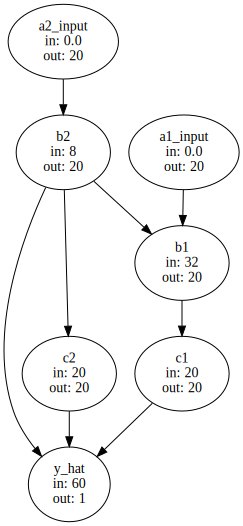

In [ ]:
dot = Digraph()
for key in tqdm(kegg_connections.keys()):
    key_label = str(key)+'\nin: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
    dot.node(key, key_label)
    for value in kegg_connections[key]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    

dot

In [ ]:
str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])

In [ ]:
# simple case where there is a single value for everything

# connection matrix
key_order = list(temp.keys()); key_order.reverse(); key_order = tuple(key_order)
key_order = dict(zip(key_order, [i for i in range(len(key_order))]))


# connection matrix will be of size num_nodes x num_nodes
num_nodes = len(key_order.keys())

i_s = []
j_s = []
for key in key_order.keys():
    i  = key_order[key]
    jj = [key_order[e] for e in temp[key]]
    if jj == []:
        pass
    else:
        ii = [i for ii in range(len(jj))]
        i_s += ii
        j_s += jj


ijs = [i_s, j_s]
vs  = [1.0 for i in range(len(i_s))]

connection_matrix = torch.sparse_coo_tensor(ijs, vs, (num_nodes, num_nodes))

connection_matrix, connection_matrix.to_dense()



In [ ]:
# "data"
dat = torch.zeros(num_nodes)
dat[key_order['a1_input']] = 1
dat[key_order['a2_input']] = 1
dat

In [ ]:
# weight_1 = torch.zeros((num_nodes, num_nodes))+2
weight_1 = torch.randn((2, num_nodes))
weight_1

In [ ]:
weight_1[0, :] = 0.0 
torch.nn.functional.linear(dat,  weight_1)

In [ ]:
dat @ (connection_matrix * weight_1).T

# (weight_1 @ connection_matrix).to_dense()

In [ ]:
x = torch.randn(3, 3)
x[:, 1] = 0.0
x[1, :] = 0.0
x.to_sparse()

In [ ]:
in_features_list = [1, 1]
out_features_list= [2, 3]




In [ ]:
xlin = nn.Linear(2, 3)

In [ ]:
xlin.weight[:, 1] = 0.0

In [ ]:
xlin.get_parameter('weight')
xlin.get_parameter('bias')

In [ ]:

# input        mask    
# [[a, b], -> [[1, 0],
#  [c, d]]     [0, 0]]

# init with the input, output sizes and mask for input. 
# returned tensor will be 

class SparseLinearUpdate(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)
    



In [ ]:
??nn.Linear

In [ ]:

nodes_to_add = list(temp.keys())
nodes_added = []
layer_dict = {}

for i in range(10):
    if nodes_to_add == []:
        pass
    else:
        if i == 0:
            nodes_at_level = [e for e in nodes_to_add if temp[e] == []]
        else:
            nodes_at_level = [e for e in nodes_to_add if False not in [ee in nodes_added for ee in temp[e]]]
        
        layer_dict[i] = nodes_at_level
        nodes_added = nodes_added+nodes_at_level

        nodes_to_add = [e for e in nodes_to_add if e not in nodes_added]


layer_dict
# print(nodes_added)

In [ ]:
# levelwise inputs
layer_dict_dependencies = {}
layer_dependencies = []

layer_num = max(list(layer_dict.keys()))

for i in range(layer_num+1): 
    i = layer_num - i
    # print(i)
   
    layer_dependencies = sum([temp[e] for e in layer_dict[i]], []) # sum flattens the list
    
    if i+1 < layer_num:  # below highest layer
        # find the values that are needed by a later layer 
        layer_passthroughs = layer_dict_dependencies[i+1]
        layer_passthroughs = [e for e in layer_passthroughs.keys() if layer_passthroughs[e] ]
        layer_dependencies = layer_dependencies + layer_passthroughs

    if i > 0: # above lowerst layer
        layer_dict_dependencies[i] = dict(zip(
                layer_dependencies,
                # if depend is in the n-1 layer then it is a float. Otherwise it needs to be passed from a previous layer so the weight will always be 1
                [True if e in layer_dict[i-1] else False for e in layer_dependencies]
            ))
    else:
        layer_dict_dependencies[i] = dict(zip(
            layer_dependencies,
            # if depend is in the n-1 layer then it is a float. Otherwise it needs to be passed from a previous layer so the weight will always be 1
            [True for e in layer_dependencies]
        ))

layer_dict_dependencies # True is 

In [ ]:
# temp
layer_dict, layer_dict_dependencies

In [ ]:
inp = torch.concat([
    input_tensor_dict['a1_input'].reshape(-1, 4*3),
    input_tensor_dict['a2_input'].reshape(-1, 4*2)
], axis = 1)

inp_slices = {
    'a1_input': [0, 12],
    'a2_input': [12, 20]
}

In [ ]:
px.imshow(inp[:, inp_slices['a2_input'][0]:inp_slices['a2_input'][1]])



In [ ]:
i = 2
layer_dependencies = sum([temp[e] for e in layer_dict[i]], [])  
layer_dependencies

In [ ]:
layer_dict[i-1]